In [546]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd

import sys
sys.path.append('../../include/')
import hhtools
import hhsignal

plt.rcParams["figure.facecolor"] = "w"

## Appendix: add dataset

In [184]:
fname = "./burst_info_data2.pkl"

with open(fname, "rb") as fp:
    burst_info = pkl.load(fp)
print(burst_info.keys())

df_burst = align_burst(burst_info)
print(burst_info["params"])

dict_keys(['burst_f', 'burst_range', 'burst_amp', 'cluster_id', 'pop_type', 'params'])
{'std_min': 3.3, 'std_max': 8, 'std_step': 0.1, 'nmin_width': 5}


In [151]:
nc = 1
pop_type = 0


def read_burst(df, target_cluster_id=0, target_pop_type=-1):
    cond = (df["cluster_id"] == target_cluster_id) & (df["pop_type"] == target_pop_type)
    return df[cond]


burst_sub = read_burst(df_burst, target_cluster_id=1, target_pop_type=0)

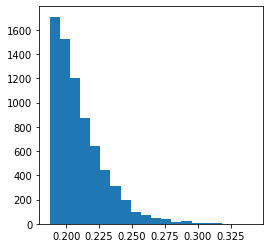

In [152]:
plt.figure(figsize=(4,4))
plt.hist(burst_sub["burst_amp"], 20)
plt.show()

In [153]:
def draw_hist(df, target_cluster_id, figsize=(9, 3.5), dpi=120,
              f_range=(10, 100), amp_range=(0.1, 0.3), t_range=(0., 1), nbin=40,
              norm=False):
    
    keys = ("burst_f", "burst_amp", "burst_duration")
    key_range = (f_range, amp_range, t_range)
    key_labels = (r"$f_{center}$ (Hz)", r"$\langle A \rangle$", r"$T$ (s)")
    cs = ("r", "b")
    pop_labels = (r"$Fast$", r"$Slow$")
    
    num_burst = []
    fig, axs = plt.subplots(1, 3, figsize=figsize, dpi=dpi)
    for n in range(2):
        burst_sub = read_burst(df_burst, target_cluster_id=target_cluster_id, target_pop_type=n)
        num_burst.append(len(burst_sub["burst_f"]))
        for i in range(3):
            r = key_range[i]
            edges = np.linspace(r[0], r[1], nbin)
            
            if keys[i] == "burst_duration":
                dt = 0.15
                edges = np.arange(r[0], r[1]+dt/2, dt)
                
            hist_bin, _ = np.histogram(burst_sub[keys[i]], bins=edges, density=False)
            if norm:
                hist_bin = np.array(hist_bin) / np.sum(hist_bin)
            
            x = (edges[1:] + edges[:-1])/2
            axs[i].plot(x, hist_bin, '.--', lw=1, ms=5, c=cs[n], label=pop_labels[n])
            axs[i].set_xlabel(key_labels[i], fontsize=13)
    
    for i in range(3):
        axs[i].legend(loc="upper right")
        
    plt.suptitle("Cluster id = %d (# burst = %d(F),%d(S))"%(target_cluster_id, num_burst[0], num_burst[1]),
                 fontsize=14, weight="bold")
        
    plt.tight_layout()
    return fig
    

In [191]:
K = len(df_burst["cluster_id"].unique())
range_set = [{} for _ in range(K+1)]
for nc in range(1, K):
    range_set[nc]["f_range"] = (10, 90)
    range_set[nc]["amp_range"] = (0.18, 0.4)
    range_set[nc]["t_range"] = (0, 1.2)

# hard fix
# range_set[0]["amp_range"]  = (0.18, 1.2)

range_set[5]["amp_range"]  = (0.5, 1.2)
range_set[6]["amp_range"]  = (0.28, 0.7)
range_set[7]["amp_range"]  = (0.28, 0.7)
range_set[8]["amp_range"]  = (0.5, 1.2)
range_set[9]["amp_range"]  = (0.28, 0.7)
range_set[10]["amp_range"] = (0.28, 0.7)
range_set[11]["amp_range"] = (0.5, 2)
range_set[12]["amp_range"] = (0.5, 1.2)
range_set[13]["amp_range"] = (0.5, 1.2)
range_set[14]["amp_range"] = (0.5, 2)
range_set[15]["amp_range"] = (0.5, 1.2)

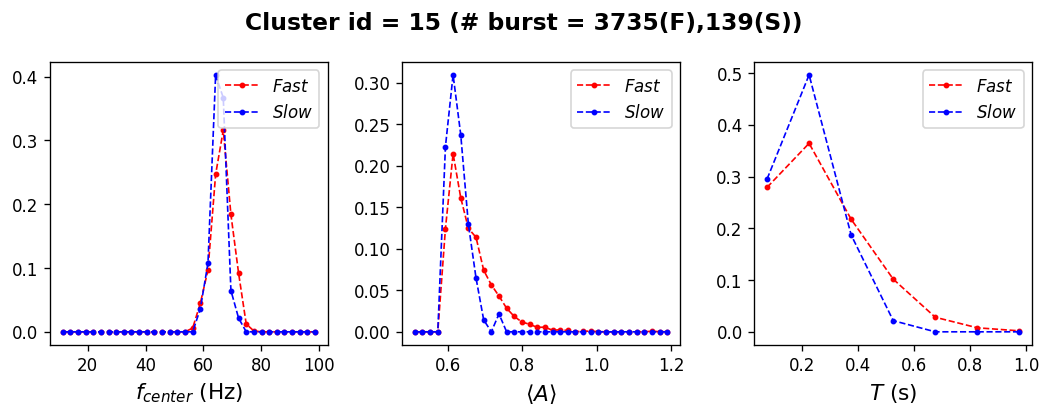

In [192]:
nc = 15
fig = draw_hist(df_burst, nc, norm=True, **range_set[nc], nbin=35)

In [ ]:
for nc in range(1, K+1):
    fig = draw_hist(df_burst, nc, norm=True, **range_set[nc], nbin=35)
    fig.savefig("./figs/burst_info_%02d.png"%(nc), dpi=150)

## Gen joint histogram

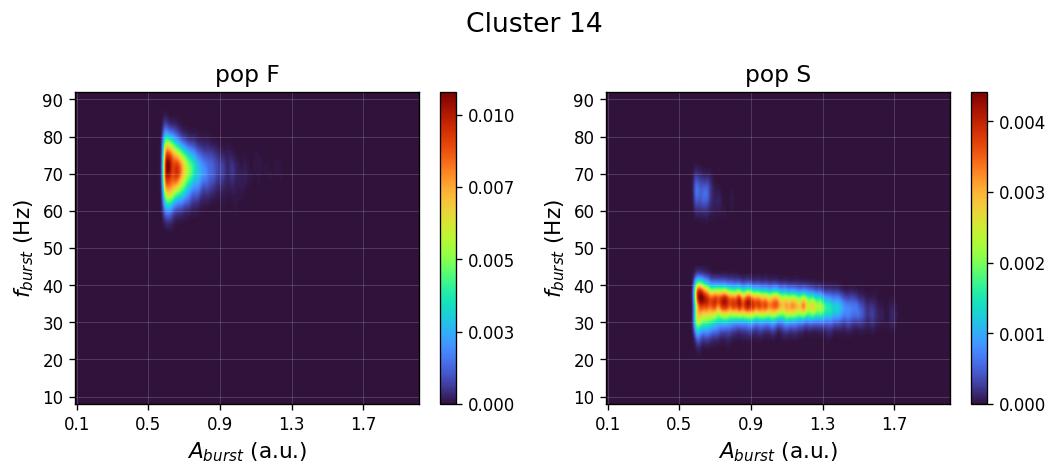

In [552]:
frange = (10, 90)
arange = (0.1, 2)
df = 2
da = 0.01
sigma = (df, da)

cid = 14

def set_labels(frange=None, arange=None, show_xlb=True, show_ylb=True, show_grid=True):
    if show_xlb: plt.xlabel(r"$A_{burst}$ (a.u.)", size=13)
    if show_ylb: plt.ylabel(r"$f_{burst}$ (Hz)", size=13)
    if show_grid: plt.grid(True, lw=0.5, c='w', alpha=0.2)
    plt.yticks(np.arange(frange[0], frange[1]+1, 10))
    plt.xticks(np.arange(arange[0], arange[1]+0.1, 0.4))
    cbar = plt.colorbar(format=lambda x, pos: "{:.3f}".format(x))
    cbar.ax.locator_params(nbins=5)
    
def set_range(val, vlim, dv):
    # set min
    nv = int((np.min(val) - vlim[0])/dv)
    if nv > 0:
        vl_min = 0
    else:
        pass
    
    
    # (np.min(val) - vlim[0])/dv
    # (vlim[1] - vlim[0])/dv

lb_tp = ("F", "S")
plt.figure(dpi=120, figsize=(9, 4))
for tp in range(2):
    joint, _, adj_crange = compute_joint(df_burst, cid=cid, pop_type=tp, itv=(df, da), row_range=frange, col_range=arange, sigma=sigma)

    plt.subplot(1,2,tp+1)
    draw_joint_map(joint, frange, arange, cmap=cmaps[tp], interpolation="spline16")
    set_labels(frange=frange, arange=arange)
    plt.title("pop %s"%(lb_tp[tp]), fontsize=14)

plt.suptitle("Cluster %d"%(cid), fontsize=16)
plt.tight_layout()
plt.show()

## Generate burst joint map 

In [565]:
frange = (10, 90)
arange = (0.1, 2)
df = 2
da = 0.01
sigma = (df, da)

lb_tp = ("F", "S")
for cid in range(1, 16):
    
    amax = np.max(df_burst[df_burst["cluster_id"] == cid]["burst_amp"])
    col_range = [arange[0], min([arange[1], (int((amax-0.1) // 0.5) + 1) * 0.5])]
    
    plt.figure(dpi=120, figsize=(9, 4))
    for tp in range(2):
        joint, _, adj_crange = compute_joint(df_burst, cid=cid, pop_type=tp, itv=(df, da), row_range=frange, col_range=col_range, sigma=sigma)

        plt.subplot(1,2,tp+1)
        draw_joint_map(joint, frange, col_range, cmap=cmaps[tp], interpolation="spline16")
        set_labels(frange=frange, arange=col_range)
        plt.title("pop %s (n=%d)"%(lb_tp[tp], np.sum((df_burst["cluster_id"] == cid) & (df_burst["pop_type"]==tp))), fontsize=14)

    plt.suptitle("Cluster %d"%(cid), fontsize=16)
    plt.tight_layout()
    plt.savefig("./joint_maps/cid%02d.png"%(cid), dpi=150)
    plt.clf()
    # plt.show()

burst_f exceeds expected range, max: 96.10
burst_amp exceeds expected range, max: 0.51
burst_f exceeds expected range, max: 99.10
burst_amp exceeds expected range, max: 2.04


<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

In [440]:
amp = df_burst["burst_amp"][10]

In [441]:
amp

0.2186892515753604

## Check individual

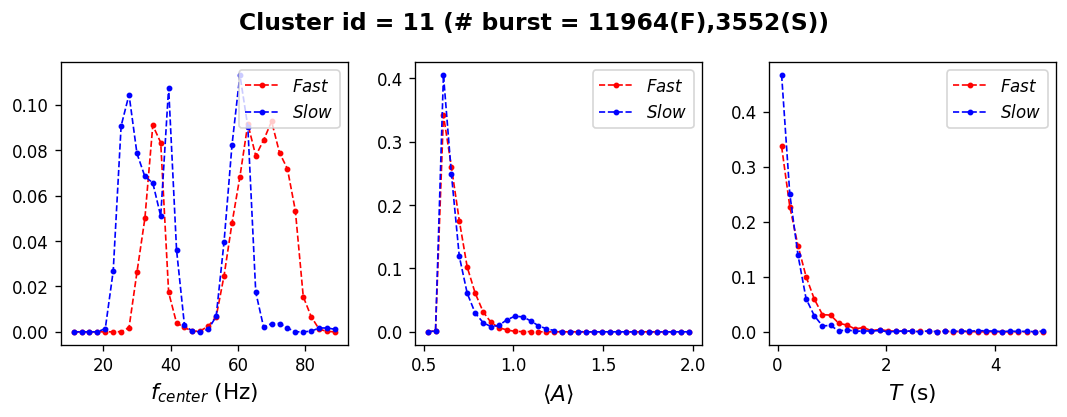

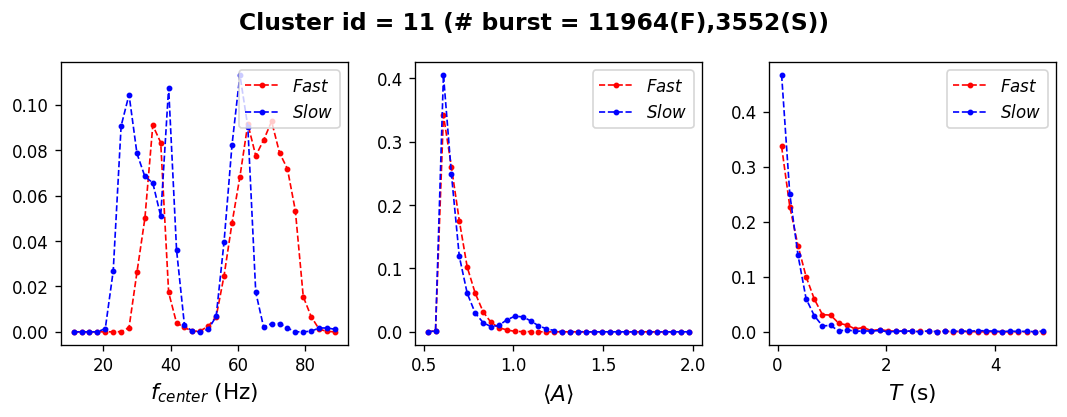

In [151]:
nc = 11

range_tmp = {
    "f_range": (10, 90),
    "amp_range": (0.5, 2),
    "t_range": (0, 5)
}

draw_hist(df_burst, nc, norm=True, **range_tmp, nbin=35)

In [97]:
import sys
sys.path.append("../../include/")

import hhsignal
import hhtools
import burst_tools as bt

summary_obj = hhtools.SummaryLoader("../data/")
with open("./th_data.pkl", "rb") as fp:
    th_buf = pkl.load(fp)
print(th_buf["std_ratio"])

3.29


In [102]:
reload(bt)

<module 'burst_tools' from '/home/jungyoung/Project/hh_neuralnet/gen_three_pop_samples/multifreq_burst/burst_tools.py'>

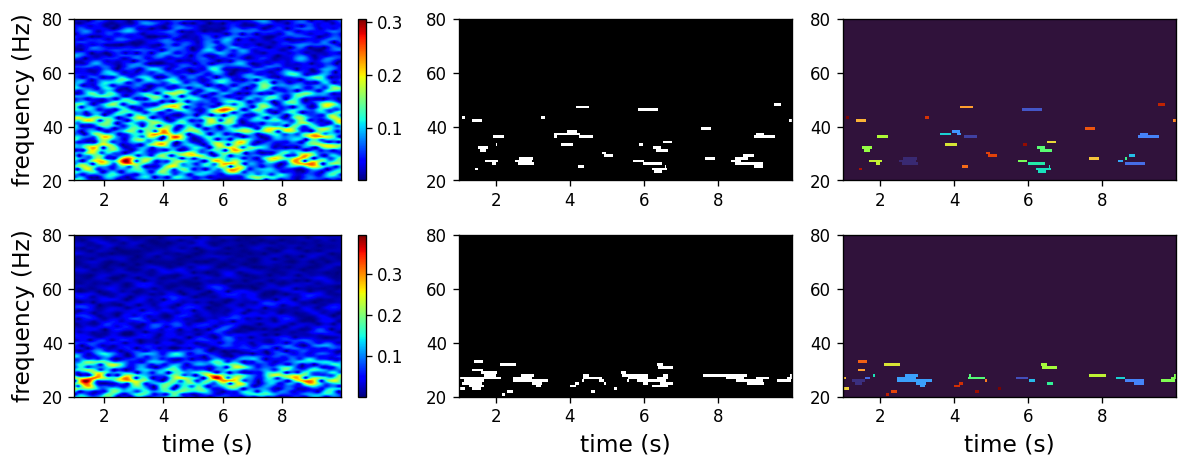

In [111]:
nc = 2
nitr = 50
flim_show = (20, 80)

flim = th_buf["psd_params"]["flim"]
wbin_t = th_buf["psd_params"]["wbin_t"]
mbin_t = th_buf["psd_params"]["mbin_t"]

nid = summary_obj.get_id(nc-1, nitr)
detail_data = summary_obj.load_detail(nc-1, nitr)

def cut_start(signal, t):
    idt = (t >= 0.5)
    return signal[idt], t[idt]

fig, axs = plt.subplots(2, 3, figsize=(10, 4), dpi=120, facecolor='w')

for tp in range(2):
    vlfp, t = cut_start(detail_data["vlfp"][tp+1], detail_data["ts"])
    psd, fpsd, tpsd = hhsignal.get_stfft(vlfp, t, 2000, mbin_t=mbin_t, wbin_t=wbin_t, frange=flim)
    
    ## old version
    pth = th_buf["th_m"][nid, tp] + 3.3 * th_buf["th_s"][nid, tp]
    # im_bin = psd >= pth
    # im_class = bt.find_blob(im_bin)
    # burst_f, burst_range, burst_amp = bt.extract_burst_attrib(psd, fpsd, im_class)
    
    burst_map = bt.find_blob_filtration(psd, th_buf["th_m"][nid, tp], th_buf["th_s"][nid, tp],
                                        std_min=3.3, std_max=8, std_step=0.1, nmin_width=int(0.05 // mbin_t))
    burst_f, burst_range, burst_amp = bt.extract_burst_attrib(psd, fpsd, burst_map)
    

    xlb = "time (s)" if tp == 1 else None
    bt.draw_binarize_psd(psd, pth, x=tpsd, y=fpsd, flim=flim_show, ylabel="frequency (Hz)", xlabel=xlb, axs=axs[tp][:2])

    plt.axes(axs[tp][2])
    hhtools.imshow_xy(burst_map, x=tpsd, y=fpsd, cmap="turbo", interpolation="none")
    
    # bt.draw_burst_attrib(im_class, burst_f, burst_range, tpsd=tpsd, fpsd=fpsd, flim=flim_show)
    
    plt.xlabel(xlb, fontsize=14)
    plt.ylim(flim_show)
    plt.tight_layout()

# plt.savefig("./figs/burst_sample.png", dpi=150)
plt.show()

In [109]:
3/100

0.03

## Filtration 

In [1]:
from importlib import reload
import burst_tools as bt
reload(bt)
import pickle as pkl
import hhsignal

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../../include/")

import hhsignal
import hhtools
import burst_tools as bt

summary_obj = hhtools.SummaryLoader("../data/")
with open("./th_data2.pkl", "rb") as fp:
    th_buf = pkl.load(fp)
print(th_buf["std_ratio"])

3.29


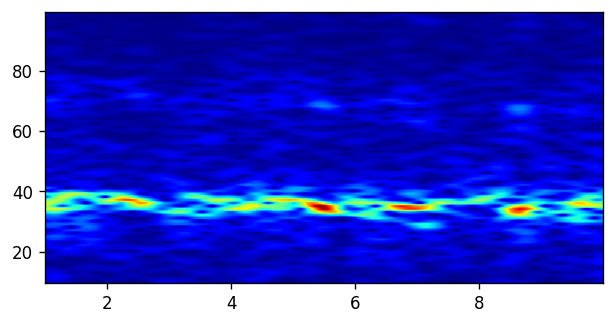

In [87]:
nc = 8
tp  = 1
nitr = 50
flim_show = (20, 80)

def cut_start(signal, t):
    idt = (t >= 0.5)
    return signal[idt], t[idt]

nid = summary_obj.get_id(nc-1, nitr)
detail_data = summary_obj.load_detail(nc-1, nitr)
vlfp, t = cut_start(detail_data["vlfp"][tp+1], detail_data["ts"])
psd, fpsd, tpsd = hhsignal.get_stfft(vlfp, t, 2000, mbin_t=0.01, wbin_t=1, frange=(10, 100))

plt.figure(dpi=120, figsize=(6, 3))
hhtools.imshow_xy(psd, x=tpsd, y=fpsd, cmap='jet')
plt.show()

In [88]:
reload(bt)
burst_map, null_map, im_b = bt.extract_burst_filtration(psd, fpsd,
                                        th_buf["th_m"][nid, tp], th_buf["th_s"][nid, tp],
                                        std_min=3.3, std_max=8, std_step=0.1,
                                        nmin_width=int(0.05/th_buf["psd_params"]["mbin_t"]))

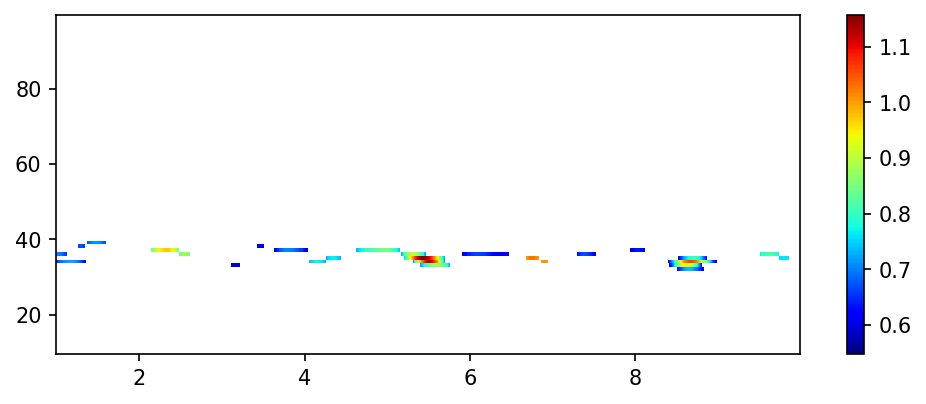

In [91]:
amap = (burst_map > 0).astype(float)
# amap[amap == 0] = 1
pth_min = th_buf["th_m"][nid, tp] + 3 * th_buf["th_s"][nid, tp]

plt.figure(dpi=150, figsize=(8, 3))
hhtools.imshow_xy(psd, alpha=amap, x=tpsd, y=fpsd, cmap="jet", interpolation="none", vmin=pth_min)
plt.colorbar()

In [95]:
width = []
for nb in range(1, np.max(burst_map)+1):
    nr, nc = np.where(burst_map == nb)
    width.append([np.max(nc) - np.min(nc)])

In [97]:
np.min(width)

7

In [65]:
test = bt.extract_burst_attrib(psd, fpsd, burst_map)

In [592]:
from dataclasses import dataclass
from typing import Tuple

@dataclass
class mfoConfig:
    mbin_t: float = 0.1
    wbin_t: float = 1
    flim: Tuple[float, float] = (10, 100)
    std_min: float = 3.3
    std_max: float = 8
    std_step: float = 0.1
    nmin_width: float = -1
    arange: Tuple[float, float] = (0.1, 2.1)
    da: float = 0.4
    fdir: str = ""

# Draw burst f-A joint probability map

In [433]:
from scipy.ndimage import gaussian_filter


def align_burst(burst_info):
    data = []
    col_names = ["burst_f", "burst_range", "burst_amp"]
    for n in range(len(burst_info["burst_f"])):
        for i in range(len(burst_info["burst_f"][n])):
            data_sub = [
                burst_info["burst_f"][n][i],
                burst_info["burst_amp"][n][i],
                burst_info["burst_range"][n][i][1] - burst_info["burst_range"][n][i][0],
                burst_info["cluster_id"][n],
                burst_info["pop_type"][n]
            ]
            data.append(data_sub)
    df_burst = pd.DataFrame(data, columns=["burst_f", "burst_amp", "burst_duration", "cluster_id", "pop_type"])
    if df_burst["cluster_id"].min() == 0:
        df_burst["cluster_id"] += 1
    
    return df_burst


def compute_joint(df_burst, cid=1, pop_type=0, itv=(2, 0.02),
                  row_range=(10, 100), col_range=(0.1, 2), sigma=(0, 0)):
    
    # row: f, col: amp
    if cid < 1: raise ValueError("Wrong cluster id")
    df_sub = df_burst[(df_burst["cluster_id"] == cid) & (df_burst["pop_type"] == pop_type)]
    
    if any(df_sub["burst_f"] >= row_range[1]):
        print("burst_f exceeds expected range, max: %.2f"%(np.max(df_sub["burst_f"])))
    
    if any(df_sub["burst_amp"] >= col_range[1]):
        print("burst_amp exceeds expected range, max: %.2f"%(np.max(df_sub["burst_amp"])))
        
    def in_range(df, df_range):
        return (df >= df_range[0]) & (df < df_range[1])
        
    df_in = df_sub[in_range(df_sub["burst_f"], row_range) & in_range(df_sub["burst_amp"], col_range)]
    
    numf = int((row_range[1] - row_range[0])/itv[0])
    numa = int((col_range[1] - col_range[0])/itv[1])
        
    joint_map = np.zeros([numf, numa])
    rset = np.floor((df_in["burst_f"] - row_range[0]) / itv[0]).astype(int)
    cset = np.floor((df_in["burst_amp"] - col_range[0]) / itv[1]).astype(int)
        
    for r, c in zip(rset, cset):
        if r >= numf: continue
        if c >= numa: continue
        
        joint_map[r, c] += 1
        
    if len(rset) > 0: joint_map /= len(rset)
    
    sigma = (int(sigma[0]/itv[0]), int(sigma[1]/itv[1]))
    joint_map = gaussian_filter(joint_map, sigma)
    
    return joint_map, len(df_in)


def adjust_range(vals, boundary, dr):
    vmin = np.min(vals)
    vmax = np.max(vals)
    
    # print(np.floor((vmin - boundary[0])/dr)*dr)# + boundary[0])
    rmin = np.max([boundary[0], np.floor((vmin - boundary[0])/dr)*dr + boundary[0]])
    rmax = np.min([boundary[1], boundary[1] - np.floor((boundary[1] - vmax)/dr).round()*dr])
    return (rmin, rmax)


def draw_joint_map(joint_map, row_range, col_range, cmap="jet", interpolation="none"):
    dr = (row_range[1] - row_range[0])/joint_map.shape[0]
    dc = (col_range[1] - col_range[0])/joint_map.shape[1]
    plt.imshow(joint_map, interpolation=interpolation, cmap=cmap,
               extent=(col_range[0]-dc, col_range[1]+dc, row_range[0]-dr, row_range[1]+dr),
               aspect="auto", origin="lower", vmin=0)
    
    
def set_labels(frange=None, arange=None, show_xlb=True, show_ylb=True, show_grid=True):
    if show_xlb: plt.xlabel(r"$A_{burst}$ (a.u.)", size=13)
    if show_ylb: plt.ylabel(r"$f_{burst}$ (Hz)", size=13)
    if show_grid: plt.grid(True, lw=0.5, c='w', alpha=0.2)
    plt.yticks(np.arange(frange[0], frange[1]+1, 10))
    plt.xticks(np.arange(arange[0], arange[1]+0.1, 0.4))
    cbar = plt.colorbar(format=lambda x, pos: "{:.3f}".format(x))
    cbar.ax.locator_params(nbins=3)
    # print(cbar)
    
def set_range(val, vlim, dv):
    # set min
    nv = int((np.min(val) - vlim[0])/dv)
    if nv > 0:
        vl_min = 0
    else:
        pass

In [430]:
bmap_name = "./data/burst_map.pkl"
th_types = "abs"


with open(bmap_name, "rb") as fp:
    burst_info = pkl.load(fp)
df_burst = align_burst(burst_info)

In [716]:
burst_info.keys()

dict_keys(['burst_f', 'burst_range', 'burst_amp', 'cluster_id', 'pop_type', 'params'])

In [730]:
burst_info["params"]

{'std_min': 3.3, 'std_max': 8.0, 'std_step': 0.1, 'nmin_width': 5}

In [725]:
9 * 800 + 1

7201

In [729]:
burst_info["burst_f"][7400]

array([54.56784671, 54.44768711, 53.29600407, 44.5077402 , 59.05905906,
       51.05105105, 58.05805806, 46.04604605, 53.05305305, 41.04104104,
       46.04604605])

In [726]:
burst_info["cluster_id"][7201]

9.0

In [720]:
len(burst_info["burst_f"])

12000

## Single sample 

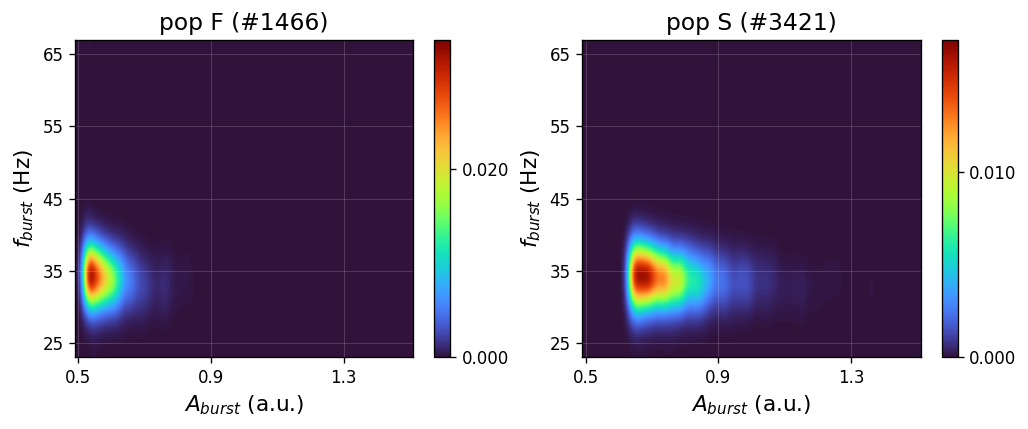

In [431]:
cid = 5

frange = (10, 90)
arange = (0.1, 2.1)
df = 2
da = 0.01
sigma = (df, da)

df_sub = df_burst[df_burst["cluster_id"] == cid]
adj_frange = adjust_range(df_sub["burst_f"], frange, 5)
adj_arange = adjust_range(df_sub["burst_amp"], arange, 0.2)

lb_tp = ("F", "S")
plt.figure(dpi=120, figsize=(10, 3.5))
for tp in range(2):
    joint, num_b = compute_joint(df_burst, cid=cid, pop_type=tp, itv=(df, da), row_range=adj_frange, col_range=adj_arange, sigma=sigma)

    plt.subplot(1,2,tp+1)
    draw_joint_map(joint, adj_frange, adj_arange, cmap="turbo", interpolation="bicubic")
    set_labels(frange=adj_frange, arange=adj_arange)
    plt.title("pop %s (#%d)"%(lb_tp[tp], num_b), fontsize=14)
plt.show()

## Export all samples

In [432]:
# cid = 15

frange = (10, 90)
arange = (0.1, 2.1)
df = 2
da = 0.01
sigma = (df, da)

for cid in range(1, 16):
    df_sub = df_burst[df_burst["cluster_id"] == cid]
    adj_frange = adjust_range(df_sub["burst_f"], frange, 5)
    adj_arange = adjust_range(df_sub["burst_amp"], arange, 0.2)

    lb_tp = ("F", "S")
    plt.figure(dpi=120, figsize=(9, 4))
    for tp in range(2):
        joint, num_b = compute_joint(df_burst, cid=cid, pop_type=tp, itv=(df, da), row_range=adj_frange, col_range=adj_arange, sigma=sigma)

        plt.subplot(1,2,tp+1)
        draw_joint_map(joint, adj_frange, adj_arange, cmap="turbo", interpolation="bicubic")
        set_labels(frange=adj_frange, arange=adj_arange)
        plt.title("pop %s (#%d)"%(lb_tp[tp], num_b), fontsize=14)
    
    plt.suptitle("Cluster %d (th=%s)"%(cid, th_types), fontsize=16)
    plt.tight_layout()
    plt.savefig("./joint_maps/burst_prob_%s_%02d.png"%(th_types, cid))
    plt.clf()

burst_f exceeds expected range, max: 98.93
burst_f exceeds expected range, max: 99.10
burst_amp exceeds expected range, max: 2.14
burst_f exceeds expected range, max: 98.10


<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

# Correlation between the burst 

In [595]:
def show_corr_map(corr_map, x, dpi=120, figsize=(8, 3), vm=0.2, xl=None):
    if xl is None: xl = [x[0], x[-1]]
    
    def add_ac_axis():
        def _set_spines(labels, cs, lw=1.5):
            for k in labels:
                ax.spines[k].set_color(cs)
                ax.spines[k].set_linewidth(lw)
        
        ax = plt.gca()
        # fast pop
        ax.tick_params('x', top=True, labeltop=True, color="k")
        _set_spines(("top", "left"), "r", lw=1.5)
        ax.spines["top"].set_label("Fast")

        # # slow pop
        ax.tick_params('y', right=True, labelright=True, color="b")
        _set_spines(("bottom", "right"), "b", lw=1.)
        # plt.plot(x[1:], x[:-1], 'b', lw=1.5)
        # plt.plot(x, x+1, 'k', lw=2)
    
    cmap = "RdBu_r"
    
    plt.subplot(121)
    im = np.triu(corr_map[:,:,3]) + np.tril(corr_map[:,:,0])
    for i in range(im.shape[0]):
        im[i, i] = 0
    hhtools.imshow_xy(im, x=x, y=x, cmap=cmap, vmin=-vm, vmax=vm, interpolation="none")
    plt.xlim(xl)
    plt.axis("square")
    plt.xlabel("Slow", fontsize=14)
    plt.ylabel("Fast", fontsize=14)
    add_ac_axis()
    

    plt.subplot(122)
    hhtools.imshow_xy(corr_map[:,:,1], x=x, y=x, cmap=cmap, vmin=-vm, vmax=vm, interpolation="none")
    plt.xlim(xl)
    plt.axis("square")
    plt.xlabel("Slow", fontsize=14)
    plt.ylabel("Fast", fontsize=14)

    
def show_corr_map_full(im_set, fpsd, cmap="RdBu_r", vm=0.1, fl=(15, 85), corr_label=None):
    tp_show = (0,1,3)
    ij_set = ((0, 0), (0, 1), (1, 1))
    tp_label = ("F", "S")
    
    for n, tp in enumerate(tp_show):
        plt.axes(position=(0.05+n*0.28, 0.17, 0.28, 0.73))
        
        # plt.subplot(1,3,n+1)
        im_ax = hhtools.imshow_xy(im_set[:,:,tp], x=fpsd, y=fpsd, cmap=cmap, vmin=-vm, vmax=vm, interpolation="None")
        
        i, j = ij_set[n]
        plt.xlabel(r"$f_{%s}$ (Hz)"%(tp_label[i]), fontsize=15)
        plt.ylabel(r"$f_{%s}$ (Hz)"%(tp_label[j]), fontsize=15)
        plt.axis("square")
        plt.xlim(fl)
        plt.ylim(fl)
        
    ax = plt.axes(position=(0.88, 0.17, 0.01, 0.73))
    cbar = plt.colorbar(cax=ax, ticks=[-vm, 0, vm], label=corr_label)
    cbar.set_label(corr_label, fontsize=12)
    
        
    # plt.show()

In [578]:
th_types

'abs'

In [579]:
with open("./data/corr_map1.pkl", "rb") as fp:
    corr_data = pkl.load(fp)
print(corr_data.keys())
print(corr_data["params"])

th_types = "abs"

dict_keys(['pcorr_maps', 'bcorr_maps', 'num_detected', 'amp_ranges', 'desc', 'fpsd', 'params'])
{'mbin_t': 0.01, 'wbin_t': 1, 'flim': (10, 100), 'std_min': 3.2, 'std_max': 8.0, 'std_step': 0.1, 'nmin_width': 5, 'amp_ranges': (0.1, 2.1), 'fdir': '../data'}


In [699]:
corr_data["num_detected"][8]

array([4657, 4255])

## Single sample result 

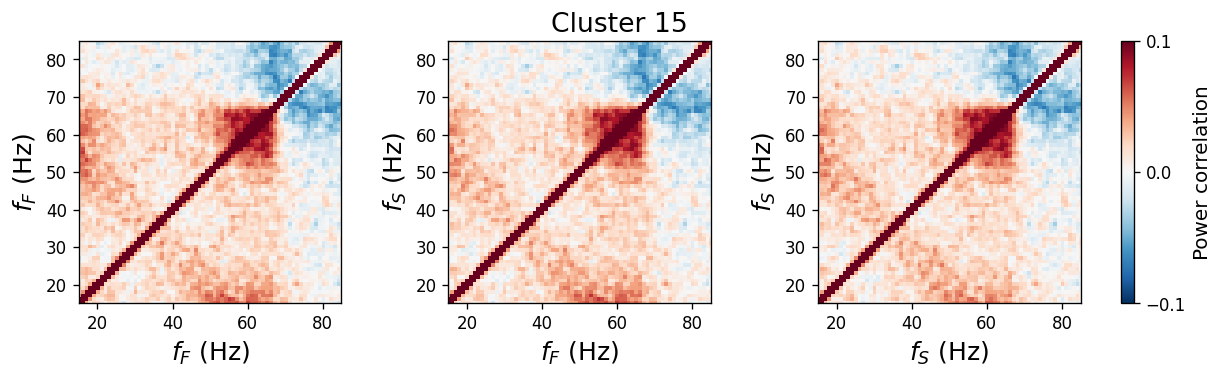

In [596]:
plt.figure(dpi=120, figsize=(11, 3))
show_corr_map_full(corr_data["pcorr_maps"][cid-1], corr_data["fpsd"], cmap="RdBu_r", vm=0.1, corr_label='Power correlation')
plt.suptitle("Cluster %d"%(cid), fontsize=16)
plt.show()

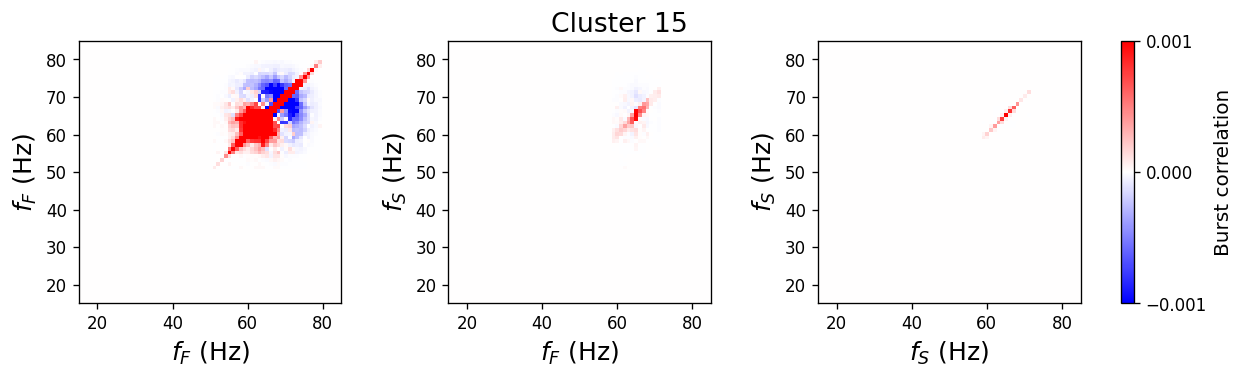

In [597]:
plt.figure(dpi=120, figsize=(11, 3))
show_corr_map_full(corr_data["bcorr_maps"][cid-1][0], corr_data["fpsd"], cmap="bwr", vm=1e-3, corr_label='Burst correlation')
plt.suptitle("Cluster %d"%(cid), fontsize=16)
plt.show()

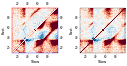

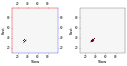

In [545]:
cid = 5

plt.figure(dpi=20, figsize=(8, 3))
show_corr_map(corr_data["pcorr_maps"][cid-1], corr_data["fpsd"], vm=0.1, xl=[15, 85])
plt.show()

plt.figure(dpi=20, figsize=(8, 3))
show_corr_map(corr_data["bcorr_maps"][cid-1][0], corr_data["fpsd"], vm=1e-3, xl=[15, 85])
plt.show()

## Export all results 

In [599]:
for cid in range(1, 16):
    plt.figure(dpi=120, figsize=(11, 3))
    show_corr_map_full(corr_data["bcorr_maps"][cid-1][0], corr_data["fpsd"], cmap="bwr", vm=1e-3, corr_label='Burst correlation')
    plt.suptitle("Cluster %d"%(cid), fontsize=16)
    plt.savefig("./corr_maps/bcorr_%s_%02d.png"%(th_types, cid))
    plt.clf()
    
    plt.figure(dpi=120, figsize=(11, 3))
    show_corr_map_full(corr_data["pcorr_maps"][cid-1], corr_data["fpsd"], cmap="RdBu_r", vm=0.1, corr_label='Power correlation')
    plt.suptitle("Cluster %d"%(cid), fontsize=16)
    plt.savefig("./corr_maps/pcorr_%s_%02d.png"%(th_types, cid))
    plt.clf()

<ipython-input-599-19a8e69898e0>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(dpi=120, figsize=(11, 3))


<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

# Effect of the bursts on the power spectrogram 

## Define functions

In [684]:
with open("./data/th_psd.pkl", "rb") as fp:
    th_psd = pkl.load(fp)

In [742]:
th_psd["psd_params"]

{'mbin_t': 0.01, 'wbin_t': 1, 'flim': (10, 100)}

In [1147]:
from scipy.optimize import curve_fit
from multiprocessing import Pool


import multifreq_correlation as mc

""" Configure Env """
summary_obj = hhtools.SummaryLoader("../data", load_only_control=True)

nmin_width = int(0.05/th_psd["psd_params"]["mbin_t"])
config = mc.mfoConfig(fdir="../data/",
                      std_min=3.3, std_max=8, std_step=0.1,
                      nmin_width=5,
                    amp_ranges=(0.1, 2.1),
                   **th_psd["psd_params"])
mc.config_params(config)


def get_bmap(args):
    job_id = args[0]
    fname  = args[1][0]
    th_psd_m = args[1][1]
    th_psd_s = args[1][2]
    
    psd_set, fpsd, tpsd = mc._get_psd_single(fname)
    bmaps, burst_f, burst_range, burst_amps = mc._get_bmap(psd_set, fpsd, th_psd_m, th_psd_s)
    return job_id, (psd_set, fpsd, tpsd, bmaps, burst_f, burst_range, burst_amps)


def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)


def bimodal(x, mu1, mu2, sgm1, sgm2, a1, a2):
    return gauss(x, mu1, sgm1, a1) + gauss(x, mu2, sgm2, a2)


from numba import jit


jit(nopython=True)
def masking(mask_map, brange):
    for tp in range(2):
        for br in brange[tp]:
            mask_map[tp, :, int(br[0]):int(br[1])] = 1
    return mask_map


def get_null_corr(psd_set, mask_map):
    # index 2 (size=3): (fast, fast), (fast, slow), (slow, slow)
    # index 3 (size=4): (bon, bon), (bon, boff), (boff, bon), (boff, boff)
    
    def znorm(im):
        m = np.average(im, axis=1)[:, np.newaxis]
        s = np.std(im, axis=1)[:, np.newaxis]
        s[s == 0] = 1
        return (im - m) /s
    
    def znorm_mask(im, mask):
        id_mask = mask[0] == 1
        im_masked = np.zeros_like(im)
        tmp = znorm(im[:, id_mask])
        im_masked[:, id_mask] = tmp
        return im_masked
    
    nf = np.shape(psd_set)[1]
    pcorr_mask = np.zeros([nf, nf, 3, 4])
    pcorr_diag = np.zeros([nf, 3, 4])
    
    tp_set = ((0, 0), (0, 1), (1, 1))
    used_points = np.zeros([3, 4])
    zpsd_set = [znorm(psd_set[0]), znorm(psd_set[1])]
    for tp in range(3):
        i, j = tp_set[tp]
        for nm in range(4):
            mi, mj = nm//2, nm%2
            if (i == j) and (mi != mj):
                continue
            
            mask_i = (mi + mask_map[i]*(-1)**mi)
            mask_j = (mj + mask_map[j]*(-1)**mj)

            mat_i = znorm_mask(psd_set[i], mask_i)
            mat_j = znorm_mask(psd_set[j], mask_j)
            
            n_used = np.sum(mask_i[0]+mask_j[0]>1)
            if n_used == 0: n_used = 1
            
            pcorr_mask[:,:,tp,nm] += (mat_i @ mat_j.T)/n_used
            used_points[tp, nm] = n_used
            
            mat_i = zpsd_set[i] * mask_i
            mat_j = zpsd_set[j] * mask_j
            pcorr_diag[:, tp, nm] = np.sum(mat_i * mat_j, axis=1) / n_used
            
    return pcorr_mask, pcorr_diag, used_points


def get_pcorr_mask(arg):
    brange = arg["brange"]
    psd_set = np.array(arg["psd_set"])
    bmap_set = np.array(arg["bmap_set"])
    
    mask_map = masking(np.zeros_like(psd_set), brange)
    pcorr_mask, pdiag, used_points = get_null_corr(psd_set, mask_map)
    bcorr = mc._get_burst_corr(bmap_set)
    
    return pcorr_mask, pdiag, bcorr, used_points


def draw_pcorr(pcorr_mask, fpsd, vm=0.1, num_pt=None, suptitle=""):
    pop_labels = ("F", "S")
    burst_labels = ("on", "off")
    
    ij_set = ((0, 0), (0, 1), (1, 1))

    plt.figure(dpi=120, figsize=(10, 8))
    for bt in range(3):
        for m in range(4):
            plt.subplot(3,4,4*bt+m+1)
            hhtools.imshow_xy(pcorr_mask[:,:,bt,m], x=fpsd, y=fpsd, cmap="RdBu_r", vmax=vm, vmin=-vm, interpolation="none")
            plt.axis("square")

            i, j = ij_set[bt]
            plt.ylabel(r"$f_{%s}$ (Hz)"%(pop_labels[i]), fontsize=12)
            plt.xlabel(r"$f_{%s}$ (Hz)"%(pop_labels[j]), fontsize=12)
            title = "%s(%s)-%s(%s) (#%d)"%(pop_labels[i], burst_labels[m//2],
                                           pop_labels[j], burst_labels[m%2],
                                           num_pt[bt][m])
            plt.title(title, fontsize=13)
    plt.suptitle(suptitle, fontsize=15)
    plt.tight_layout()
    # plt.show()
    
    
def draw_bmap(bmap, fpsd, vm=1e-3, suptitle=""):
    tp_labels = ("F", "S")
    
    plt.figure(figsize=(6,6), dpi=120)
    for tp in range(4):
        i, j = tp//2, tp%2
        plt.subplot(2,2,tp+1)
        hhtools.imshow_xy(bmap[:,:,tp], x=fpsd, y=fpsd, vmin=-vm, vmax=vm, cmap="RdBu_r")
        plt.ylabel(r"$f_{%s}$ (Hz)"%(tp_labels[i]), fontsize=14)
        plt.xlabel(r"$f_{%s}$ (Hz)"%(tp_labels[j]), fontsize=14)
    plt.suptitle(suptitle, fontsize=15)
    plt.tight_layout()
    plt.show()
    
    
def show_pdiag(pdiag):
    plt.figure(dpi=120, figsize=(8, 3))
    
    ij_set = ((0, 0), (0, 1), (1, 0))
    tp_labels = ("F", "S")
    on_labels = ("on", "off")

    for tp in range(3):
        i, j = ij_set[tp]
        plt.subplot(1,3,tp+1)
        for nr in range(4):
            if (tp != 1) and (nr in [1,2]): continue
            plt.plot(pdiag[:,tp,nr], label="%s(%s)-%s(%s)"%(tp_labels[i], on_labels[nr//2], tp_labels[j], on_labels[nr%2]))
        plt.legend(fontsize=9, loc="lower right", facecolor="none", edgecolor="none")
        plt.xlabel("Frequency (Hz)", fontsize=12)
        plt.ylabel("Power correlation", fontsize=12)
    
    plt.tight_layout()

In [755]:
cid = 14
nitr = 2

print(th_psd1["th_m"][(cid-1)*400 + nitr, :])
print(th_psd1_c["th_m"][(cid-1)*400 + nitr, :])

[0.13535945 0.1139827 ]
[0.14316047 0.1226656 ]


## Measure for singel cid 

In [1177]:
cid = 15

# Extract all psd_set

args = []
for n in range(summary_obj.num_controls[-1]):
    nid = summary_obj.get_id(cid-1, n)
    fname = os.path.join(summary_obj.fdir, "id%06d_lfp.dat"%(nid))
    args.append((n, (fname, th_psd["th_m"][nid, :], th_psd["th_s"][nid, :])))

with Pool(80) as p:
    outs = p.map(get_bmap, args)
outs = [outs[i][1] for i in np.argsort([o[0] for o in outs])]

psd_stacks  = np.array([o[0] for o in outs])
fpsd, tpsd  = outs[0][1], outs[0][2]
bmap_stacks = np.array([o[3] for o in outs], dtype=int)
burst_f     = [o[4] for o in outs]
burst_range = [o[5] for o in outs]
burst_amps  = [o[6] for o in outs]

# get hist
burst_amp_cat, burst_freq_cat = [], []
for i in range(2):
    burst_amp_cat.append(np.concatenate([b[i] for b in burst_amps]))
    burst_freq_cat.append(np.concatenate([b[i] for b in burst_f]))

### Draw amplitude histogram

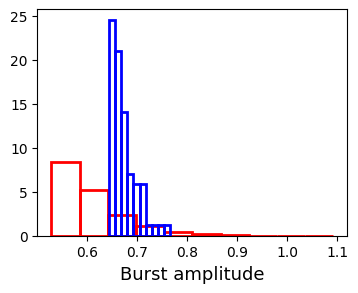

In [1179]:
cs = ["r", "b"]

plt.figure(figsize=(4, 3), dpi=100)
for i in range(2):
    plt.hist(burst_amp_cat[i], facecolor="none", edgecolor=cs[i], density=True, lw=2)
plt.xlabel("Burst amplitude", fontsize=13)
plt.show()

### Draw burst frequency histogram 

66.75413507804285

65.26856173137678



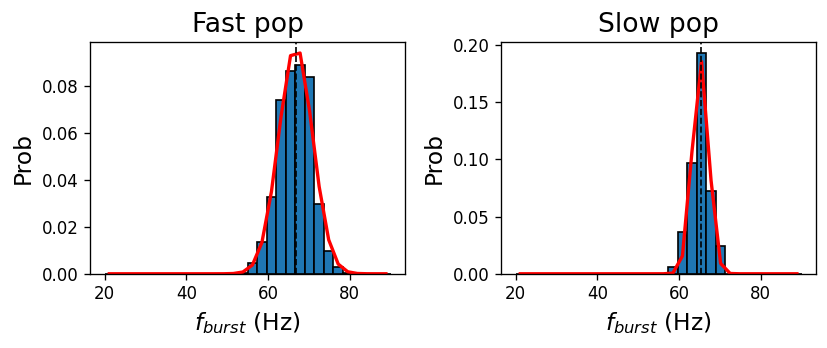

In [1180]:
gorders = [1, 1]


options = [[],
           dict(p0=(50, 5, 0.01), bounds=[(20, 1, 0), (90, 10, 1)]),
           dict(p0=(30, 50, 5, 5, 0.1, 0.005), bounds=[(20, 30, 1., 1., 0, 0), (60, 90, 10, 10, 1, 1)]),
]

fedge = np.linspace(20, 90, 31)
x = (fedge[1:] + fedge[:-1])/2

tp_labels = ("Fast pop", "Slow pop")

fpeaks = []
plt.figure(dpi=120, figsize=(7, 3))
for tp in range(2):
    plt.subplot(1,2,tp+1)
    bins, _ = np.histogram(burst_freq_cat[tp], fedge, density=True)
    
    if np.nansum(bins) == 0:
        fpeaks.append([])
        continue
    
    go = gorders[tp]
    fit_func = lambda *args: gauss(*args) if go == 1 else bimodal(*args)
    params, cov = curve_fit(fit_func, x, bins, **options[go])
    
    plt.bar(x, bins, width=(x[1]-x[0]), edgecolor='k', lw=1)
    plt.plot(x, fit_func(x, *params), c='r', lw=2)
    
    yl = plt.ylim()
    fpeaks.append([])
    for i in range(go):
        plt.plot([params[i]]*2, yl, 'k--', lw=1)
        print(params[i])
        fpeaks[-1].append(params[i])
    
    plt.xlabel(r"$f_{burst}$ (Hz)", fontsize=14)
    plt.ylabel(r"Prob", fontsize=14)
    plt.title(tp_labels[tp], fontsize=16)
        
    if go == 2:
        sgm_x = (params[1] - params[0]) / (params[3] + params[2])
        fpeaks[-1].append(params[0] + sgm_x*params[2])
    
    plt.ylim(yl)
    print()
    
plt.tight_layout()
plt.show()

### Pwr correlation test 

In [ ]:


def znorm(im):
    m = np.average(im, axis=1)[:, np.newaxis]
    s = np.std(im, axis=1)[:, np.newaxis]
    return (im - m) /s


def znorm_mask(im, mask):
    id_mask = mask[0] == 1
    im_mask = im[:, id_mask]
    return znorm(im_mask)


def lower_fres(im, fpsd, fpsd_new):
    df = (fpsd_new[1] - fpsd_new[0])/2
    edges = np.linspace(fpsd_new[0]-df, fpsd_new[-1]+df, len(fpsd_new)+1)
    im_new = np.zeros([len(fpsd_new), im.shape[1]])
    for nf in range(len(edges)-1):
        idf = (fpsd >= edges[nf]) & (fpsd < edges[nf+1])
        im_new[nf, :] = np.average(im[idf, :], axis=0)
        
    return im_new


fnew = np.arange(10, 91, 2)

num = 400
num_used = np.zeros([num, 2])
pc1, pc2 = 0, 0
pamp = np.zeros([len(fpsd), 2])
for nid in range(num):
    psd = psd_stacks[nid][1].copy()
    bmap = bmap_stacks[nid][1].copy()
    br = burst_range[nid].copy()
    
    # psd = lower_fres(psd, fpsd, fnew)

    norm_psd = znorm(psd)
    mask = masking(np.zeros([2, psd.shape[0], psd.shape[1]]), br)[1]
    
    nm1 = np.sum(mask[0])
    # norm_mask1 = znorm_mask(psd, mask)
    norm_mask1 = norm_psd * mask
    pc1 += (norm_mask1 @ norm_mask1.T) / nm1

    nm2 = np.sum(1-mask[0])
    norm_mask2 = norm_psd * (1-mask)
    # norm_mask2 = znorm_mask(psd, 1-mask)
    pc2 += (norm_mask2 @ norm_mask2.T) / nm2
    
    norm_psd = znorm(psd)
    
    x1 = norm_psd * mask
    pamp[:, 0] += np.diag(x1 @ x1.T) / nm1
    x2 = norm_psd * (1 - mask)
    pamp[:, 1] += np.diag(x2 @ x2.T) / nm2
    

    num_used[nid, :] = [nm1, nm2]
    
pc1 /= num
pc2 /= num
pamp /= num    

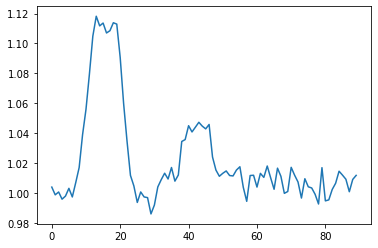

In [ ]:
plt.plot(np.diag(pc1))

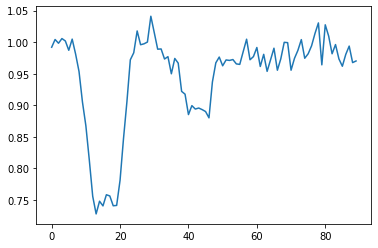

In [ ]:
plt.plot(np.diag(pc2))

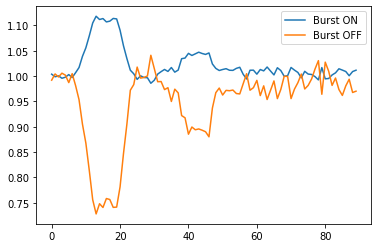

In [ ]:
plt.figure()
plt.plot(pamp[:, 0], label="Burst ON")
plt.plot(pamp[:, 1], label="Burst OFF")
plt.legend()
plt.show()

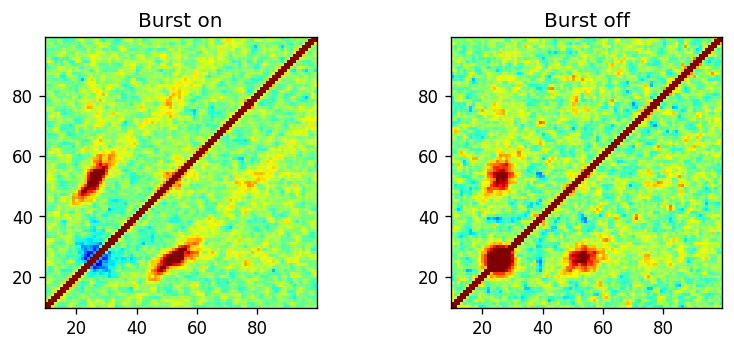

In [ ]:
vm = 0.1
extent = (fpsd[-1], fpsd[0], fpsd[0], fpsd[-1])

plt.figure(figsize=(8, 3), dpi=120)
plt.subplot(121)
# plt.imshow(pc1, extent=extent, vmin=-vm, vmax=vm, cmap="jet")
hhtools.imshow_xy(pc1, x=fpsd, y=fpsd, vmin=-vm, vmax=vm, cmap="jet", interpolation="none")
plt.axis("square")
plt.title("Burst on")

plt.subplot(122)
hhtools.imshow_xy(pc2, x=fpsd, y=fpsd, vmin=-vm, vmax=vm, cmap="jet", interpolation="none")
plt.axis("square")
plt.title("Burst off")

plt.show()


In [ ]:
# extract
args = []
for n in range(200):
    brange = []
    bmaps = []
    # bmap = bmap_stacks[n].copy()
    for tp in range(2):
        idf = (burst_f[n][tp] >= franges[tp][0]) & (burst_f[n][tp] < franges[tp][1])
        brange.append(burst_range[n][tp][idf])

        tmp_bmap = bmap_stacks[n][tp].copy()
        nids = np.where(~idf)[0]
        for nc in nids:
            tmp_bmap[tmp_bmap == nc] = 0
        bmaps.append(tmp_bmap)

    args.append(dict(brange=brange, psd_set=psd_stacks[n], bmap_set=np.array(bmaps)))

# with 
outs = []
for arg in tqdm(args):
    outs.append(get_pcorr_mask(arg))
    
psets = [o[0] for o in outs]
bsets = [o[1] for o in outs]
num_used = [o[2] for o in outs]

  0%|          | 0/200 [00:00<?, ?it/s]

### Get power correlation 

In [1181]:
from tqdm.notebook import trange, tqdm

nsamples = len(bmap_stacks)


pcorr_sets = []
pdiag_sets = []
bcorr_maps = []
num_used_sets  = []
set_names = [] # 0: neutral, 1: slow, 2: high

args = []
for n in range(gorders[0] * gorders[1]):
    ni, nj = n//gorders[1], n%gorders[1]
    ni = ni + 1 if gorders[0] > 1 else 0
    nj = nj + 1 if gorders[1] > 1 else 0    
    set_names.append((ni, nj))
    
    franges = [[], []]
    
    for tp, nn in enumerate([ni, nj]):
        if nn == 0:
            franges[tp] = [-np.inf, np.inf]
        elif nn == 1:
            franges[tp] = [-np.inf, fpeaks[tp][2]]
        else: # nn == 2
            franges[tp] = [fpeaks[tp][2], np.inf]
    
    # extract
    args = []
    for n in range(nsamples):
        brange = []
        bmaps = []
        # bmap = bmap_stacks[n].copy()
        for tp in range(2):
            idf = (burst_f[n][tp] >= franges[tp][0]) & (burst_f[n][tp] < franges[tp][1])
            brange.append(burst_range[n][tp][idf])
            
            tmp_bmap = bmap_stacks[n][tp].copy()
            nids = np.where(~idf)[0]
            for nc in nids:
                tmp_bmap[tmp_bmap == nc] = 0
            bmaps.append(tmp_bmap)
            
        args.append(dict(brange=brange, psd_set=psd_stacks[n], bmap_set=np.array(bmaps)))
    
    # with 
    outs = []
    for arg in tqdm(args):
        outs.append(get_pcorr_mask(arg))
    
    psets = [o[0] for o in outs]
    pdsets = [o[1] for o in outs]
    bsets = [o[2] for o in outs]
    num_used = [o[3] for o in outs]
    
    pcorr_sets.append(np.average(psets, axis=0))
    pdiag_sets.append(np.average(pdsets, axis=0))
    bcorr_maps.append(np.average(bsets, axis=0))
    num_used_sets.append(np.average(num_used, axis=0))

  0%|          | 0/400 [00:00<?, ?it/s]

/home/jungyoung/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/jungyoung/.local/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/jungyoung/.local/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jungyoung/.local/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jungyoung/.local/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [1182]:
type_names = ("All", "Slow", "Fast")

for ntp in range(gorders[0] * gorders[1]):
    
    title = "Inc %s burst in Fast pop, Inc %s burst in Slow pop (CID %d)"%(type_names[set_names[ntp][0]], type_names[set_names[ntp][1]], cid)
    
    draw_pcorr(pcorr_sets[ntp], fpsd, vm=0.1, num_pt=num_used_sets[ntp], suptitle=title)
    plt.savefig("./interaction_maps/pcorr_%02d_type%d.png"%(cid, ntp))
    plt.clf()
    
    plt.figure(dpi=120, figsize=(11, 3))
    show_corr_map_full(bcorr_maps[ntp], fpsd, cmap="bwr", vm=5e-4, fl=(15, 90))
    plt.suptitle(title, fontsize=14)
    plt.savefig("./interaction_maps/bcorr_%02d_type%d.png"%(cid, ntp))
    plt.clf()
    
    show_pdiag(pdiag_sets[ntp])
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.savefig("./interaction_maps/pdiag_%02d_type%d.png"%(cid, ntp))
    plt.clf()

<Figure size 1200x960 with 0 Axes>

<Figure size 1320x360 with 0 Axes>

<Figure size 960x360 with 0 Axes>

In [ ]:
# 차라리 min-max범위 구해서 divide?

## Correlation between the bursts 

In [1002]:
cid = 2

obj_summary = hhtools.SummaryLoader("../data", load_only_control=True)
data = obj_summary.load_detail(cid-1, 10)

psd_set = []
for n in range(3):
    psd, fpsd, tpsd = hhsignal.get_stfft(data["vlfp"][n], data["ts"], 2000, mbin_t=0.1, wbin_t=1, frange=(3, 100))
    psd_set.append(psd)
psd_set = np.array(psd_set)

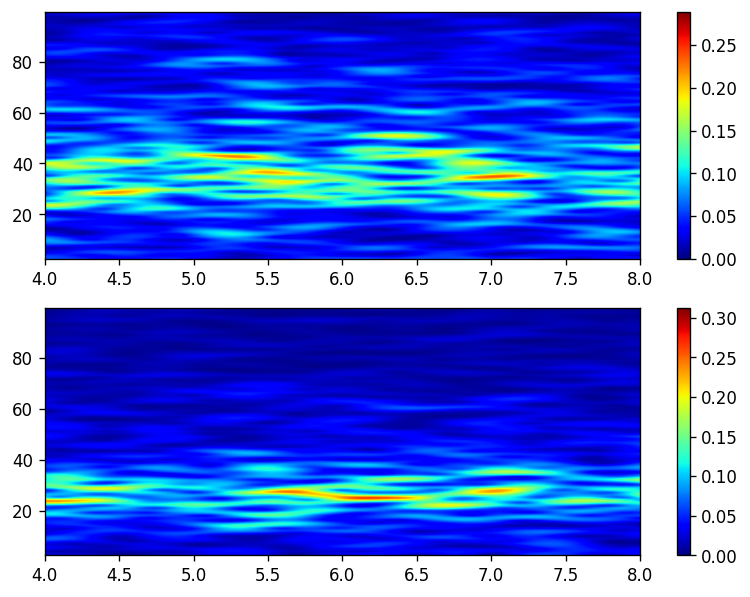

In [933]:
plt.figure(dpi=120, figsize=(8, 6))

plt.subplot(211)
hhtools.imshow_xy(psd_set[1], x=tpsd, y=fpsd, cmap="jet", interpolation="bicubic", vmin=0)
plt.xlim([4, 8])
plt.colorbar()

plt.subplot(212)
hhtools.imshow_xy(psd_set[2], x=tpsd, y=fpsd, cmap="jet", interpolation="bicubic", vmin=0)
plt.xlim([4, 8])
plt.colorbar()

plt.show()

## Effect of the burst on the power spectrogram

In [547]:
with open("./data/th_psd.pkl", "rb") as fp:
    th_psd = pkl.load(fp)

In [65]:
cinfo = []
with open("../data/picked_cluster.txt", "r") as fp:
    line = fp.readline()
    line = fp.readline()
    while line:
        cinfo.append(list(map(int, line.split(",")[:-1])))
        line = fp.readline()
    
rank_tmp = [c[2] for c in cinfo]

In [ ]:
print(th_psd["th_m"][300, :])
print(th_psd["th_s"][300, :])

[0.05470971 0.03882893]
[0.04193008 0.04177018]


In [ ]:
psd_tmp = psd_stacks[nid].copy()
psd_tmp.shape

(2, 90, 900)

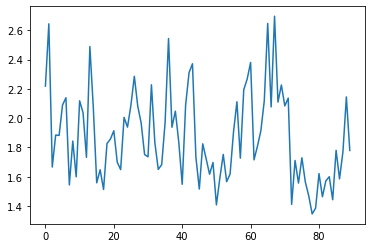

In [ ]:
plt.plot(m[1] / s[1])

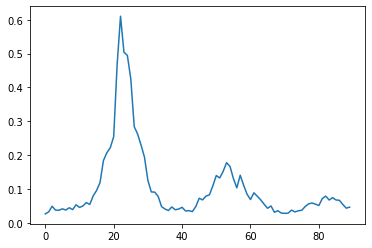

In [ ]:
plt.plot(s[1])

[0.05470971 0.03882893]


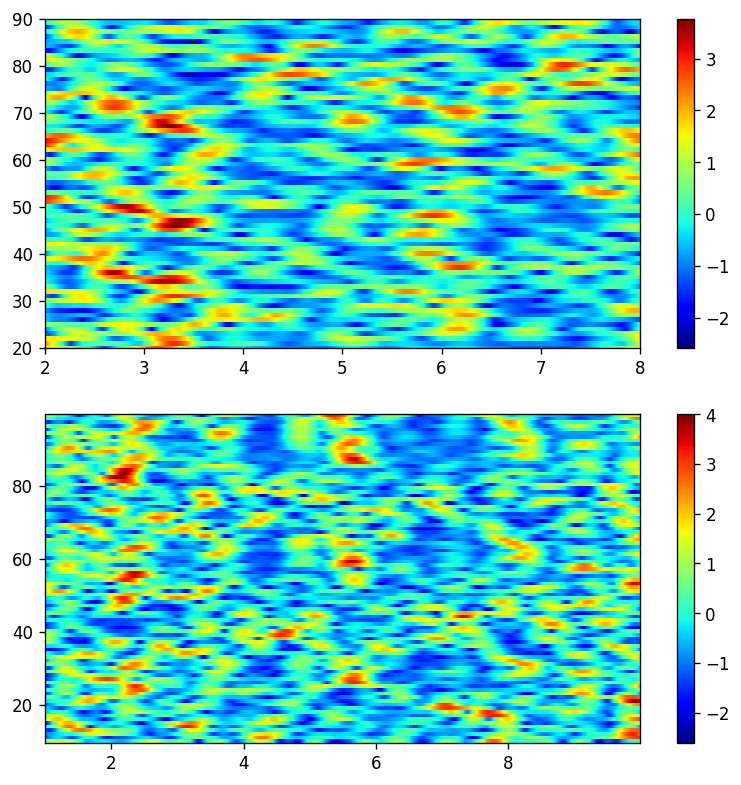

In [ ]:
# Sample figure
nid = 1

psd_tmp = psd_stacks[nid].copy()
m = np.average(psd_tmp, axis=2)[:, :, np.newaxis]
s = np.std(psd_tmp, axis=2)[:, :, np.newaxis]

norm_psd = (psd_tmp - m) / s

print(th_psd["th_m"][nid, :])

plt.figure(figsize=(8, 8), dpi=120)
plt.subplot(211)
hhtools.imshow_xy(norm_psd[0], x=tpsd, y=fpsd, cmap="jet", interpolation="none")
plt.xlim([2, 8])
plt.ylim([20, 90])
plt.colorbar()

plt.subplot(212)
hhtools.imshow_xy(norm_psd[1], x=tpsd, y=fpsd, cmap="jet", interpolation="none")
plt.colorbar()

plt.show()

[0.05470971 0.03882893]


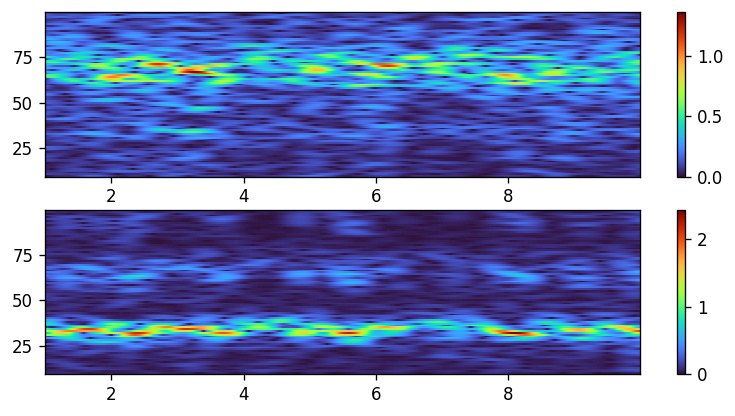

In [ ]:
# Sample figure
nid = 1

print(th_psd["th_m"][nid, :])

plt.figure(figsize=(8, 4), dpi=120)
plt.subplot(211)
hhtools.imshow_xy(psd_stacks[nid][0], x=tpsd, y=fpsd, vmin=0, cmap="turbo", interpolation="none")
plt.colorbar()

plt.subplot(212)
hhtools.imshow_xy(psd_stacks[nid][1], x=tpsd, y=fpsd, vmin=0, cmap="turbo", interpolation="none")
plt.colorbar()

plt.show()

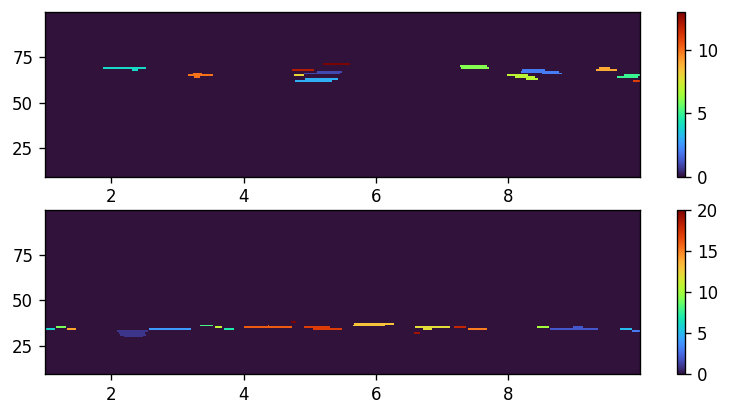

In [249]:
# Sample figuer
nid = 5

plt.figure(figsize=(8, 4), dpi=120)
plt.subplot(211)
hhtools.imshow_xy(bmap_stacks[nid][0], x=tpsd, y=fpsd, vmin=0, cmap="turbo", interpolation="none")
plt.colorbar()

plt.subplot(212)
hhtools.imshow_xy(bmap_stacks[nid][1], x=tpsd, y=fpsd, vmin=0, cmap="turbo", interpolation="none")
plt.colorbar()

plt.show()

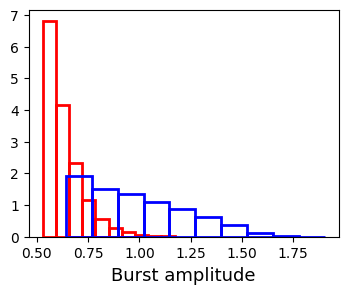

69.57479110378193

35.1520471969903



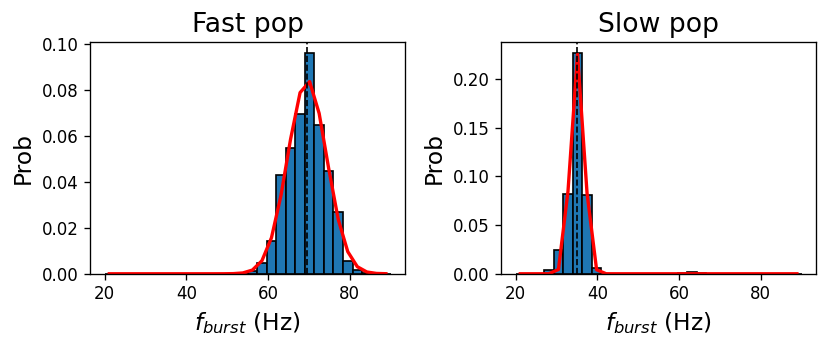

  0%|          | 0/400 [00:00<?, ?it/s]

In [133]:
num_used_sets

[array([[575.4825,   0.    ,   0.    , 324.5175],
        [409.24  , 166.2425, 210.4775, 114.04  ],
        [619.7175,   0.    ,   0.    , 280.2825]])]

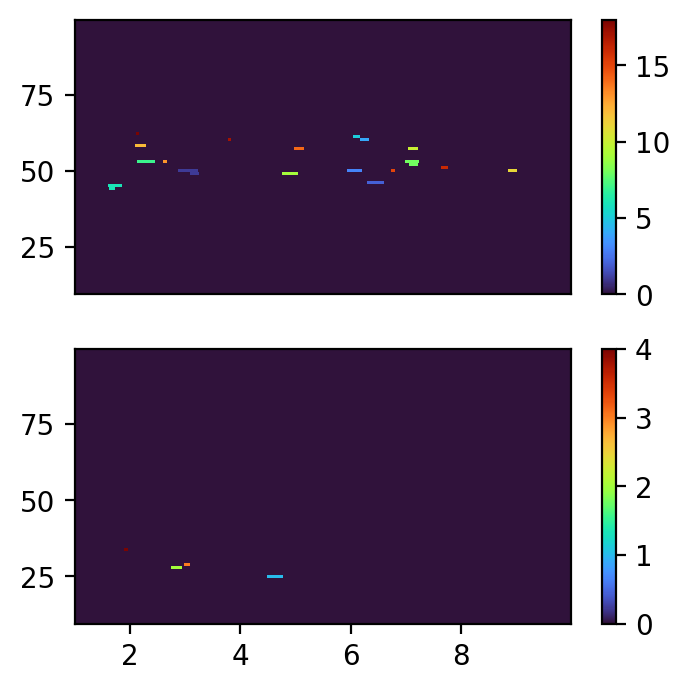

In [1172]:
plt.figure(dpi=200, figsize=(4, 4))
plt.subplot(211)
hhtools.imshow_xy(bmap_stacks[0][0], x=tpsd, y=fpsd, cmap="turbo", interpolation="none")
plt.colorbar()
plt.xticks([])

plt.subplot(212)
hhtools.imshow_xy(bmap_stacks[0][1], x=tpsd, y=fpsd, cmap="turbo", interpolation="none")
plt.colorbar()

plt.show()

In [1211]:
# divide frequency

In [1204]:
args = dict(brange=burst_range[0], psd_set=psd_stacks[0])
pc, up = get_pcorr_mask(args)

In [1091]:
def get_mask(bmap, brange):
    mask = np.zeros_like(bmap)
    for tp in range(2):
        for br in brange[tp]:
            mask[tp, :, int(br[0]):int(br[1])] = 1
    return mask # 0 (no burst) / 1 (burst exist)

ij_set = ((0, 0), (0, 1), (1, 1))
pcorr_mask = np.zeros([len(fpsd), len(fpsd), 4, 3])
for n in range(psd_stacks.shape[0]):
    psd_set = psd_stacks[n]
    m_psd = np.average(psd_set, axis=2)[:,:,np.newaxis]
    s_psd = np.std(psd_set, axis=2)[:,:,np.newaxis]
    norm_psd_set = (psd_set - m_psd) / s_psd

    # masking
    mask = get_mask(bmap_stacks[n], burst_range[n])
    
    for m in range(4):
        mi, mj = m//2, m%2

        for ntp in range(3):
            i, j = ij_set[ntp]
            mask_i = (mi + mask[i]*(-1)**mi)
            mask_j = (mj + mask[j]*(-1)**mj)
            
            mat_i = norm_psd_set[i] * mask_i
            mat_j = norm_psd_set[j] * mask_j
            n_used = np.sum(mask_i & mask_j) / len(fpsd)
            n_used = 1 if n_used == 0 else n_used
            
            pcorr_mask[:,:,m,ntp] += (mat_i @ mat_j.T)/n_used
            
pcorr_mask /= psd_stacks.shape[0]